Research on Moscow flats prices. Link for the dataset in Kaggle: https://www.kaggle.com/datasets/hugoncosta/price-of-flats-in-moscow 

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, HuberRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# Data loading

In [2]:
# download the data and glimpse on it
df = pd.read_csv(r"C:\Users\shuva\Downloads\df\df\flats_moscow.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2040 non-null   int64  
 1   price       2040 non-null   int64  
 2   totsp       2040 non-null   int64  
 3   livesp      2040 non-null   int64  
 4   kitsp       2040 non-null   float64
 5   dist        2040 non-null   float64
 6   metrdist    2040 non-null   int64  
 7   walk        2040 non-null   int64  
 8   brick       2040 non-null   int64  
 9   floor       2040 non-null   int64  
 10  code        2040 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 175.4 KB


## Variables description: 
*price* - flat price in $ 1000,   
*totsp* - total flat area in sq meters,   
*livesp* - living area in sq meters,   
*kitsp* - kitchen area in sq meters,   
*dist* - distance to the city center in km,   
*metrdist* - distance to metro station in minutes,   
*walk* - binary variable "is it possible to get to the metro on foot?" (1 - yes, 0 - no),   
*brick* - binary variable if the house is constructed of brick (1 - yes, 0 - no),   
*floor* - binary variable (0 - first or last floor, 1 - other);   

*code* - a number from 1 to 8, with which the data is grouped observations by subsamples: 1. Observations are grouped in the north, around the Kaluga-Riga metro line 2. North, around the Serpukhovsko-Timiryazevskaya metro line; 3. Northwest, around the Zamoskvoretskaya metro line; 4. Northwest, around the Tagansko-Krasnopresnenskaya metro line; 5. Southeast, around the Lublin metro line; 6. Southeast, around Tagansko-Krasnopresnenskaya metro line; 7. East, around Kalininskaya metro line; 8. East, around Arbatsko-Pokrovskaya metro line

In [3]:
# drop unnecessary column
df = df.drop(columns='Unnamed: 0')

# Initial data analysis

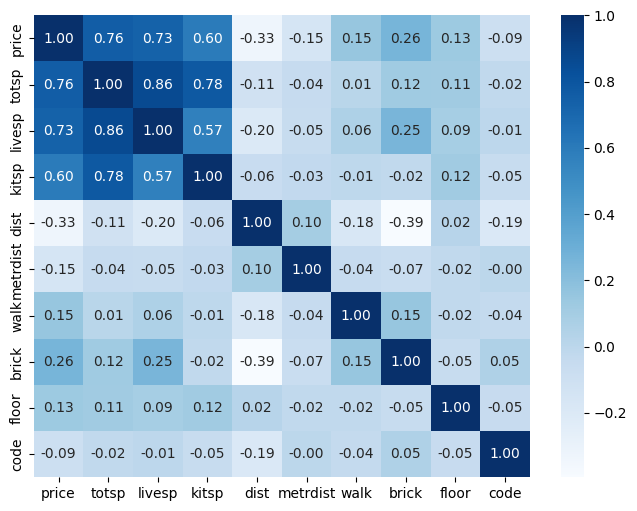

In [4]:
# let's look at linear correlations between variables
cor1 = df.corr(method='pearson')
fig = plt.figure(figsize=(8, 6))
sns.heatmap(cor1, annot=True, cmap='Blues', fmt=".2f")
plt.show()

There are strong linear correlations between price and totsp and price and livesp
Let's build scatter plots

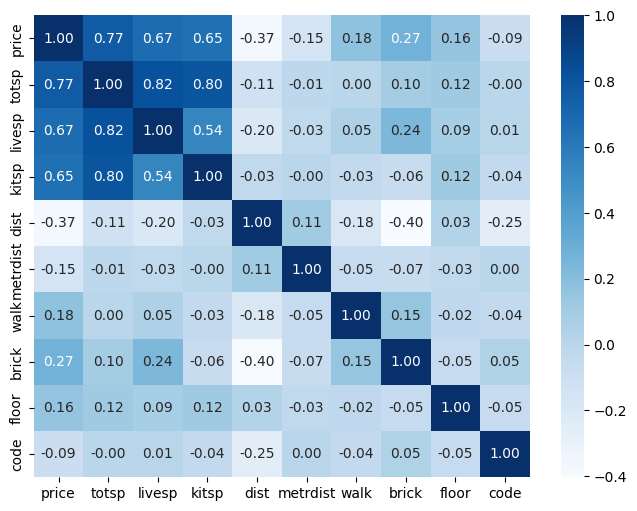

In [5]:
# let's look at non-linear correlations between variables
cor1 = df.corr(method='spearman')
fig = plt.figure(figsize=(8, 6))
sns.heatmap(cor1, annot=True, cmap='Blues', fmt=".2f")
plt.show()

Spearman rank correlations between price and totsp and kitsp is higher than linear ones, so it can indicate the presence of non-linear causation

In [6]:
# dummy variables for code
df = pd.get_dummies(df, columns=['code'], drop_first=1, dtype=int)

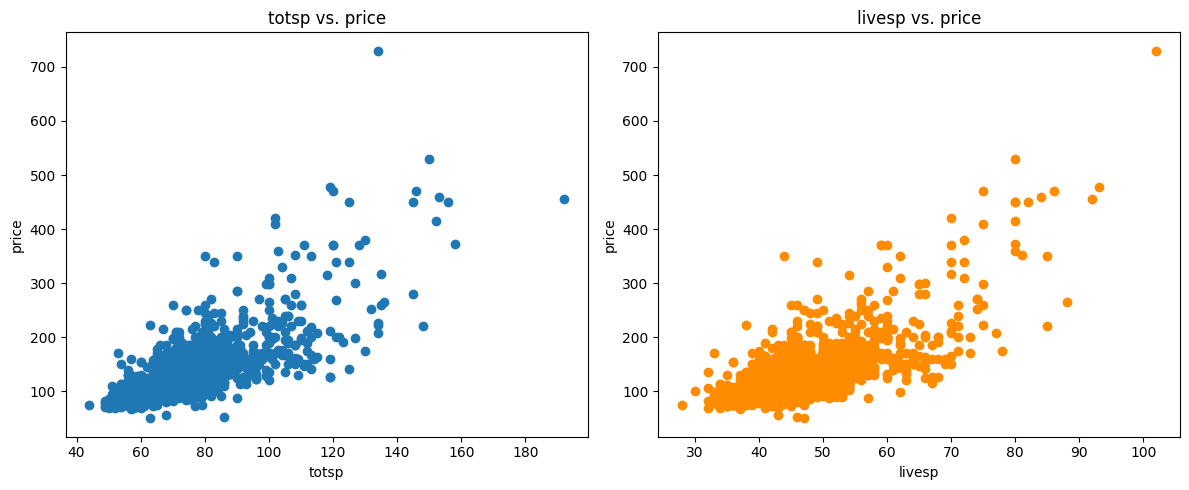

In [7]:
# scatter plot, totsp - blue, livesp - orange
# Create a figure and two subplots (one row, two columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))  # Adjust figsize as needed

# First subplot: totsp vs. price
axes[0].scatter(x=df.totsp, y=df.price)
axes[0].set_title('totsp vs. price')
axes[0].set_xlabel('totsp')
axes[0].set_ylabel('price')

# Second subplot: livesp vs. price
axes[1].scatter(x=df.livesp, y=df.price, color='darkorange')
axes[1].set_title('livesp vs. price')
axes[1].set_xlabel('livesp')
axes[1].set_ylabel('price')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

We better use natural log of price, and that of totsp and of livesp

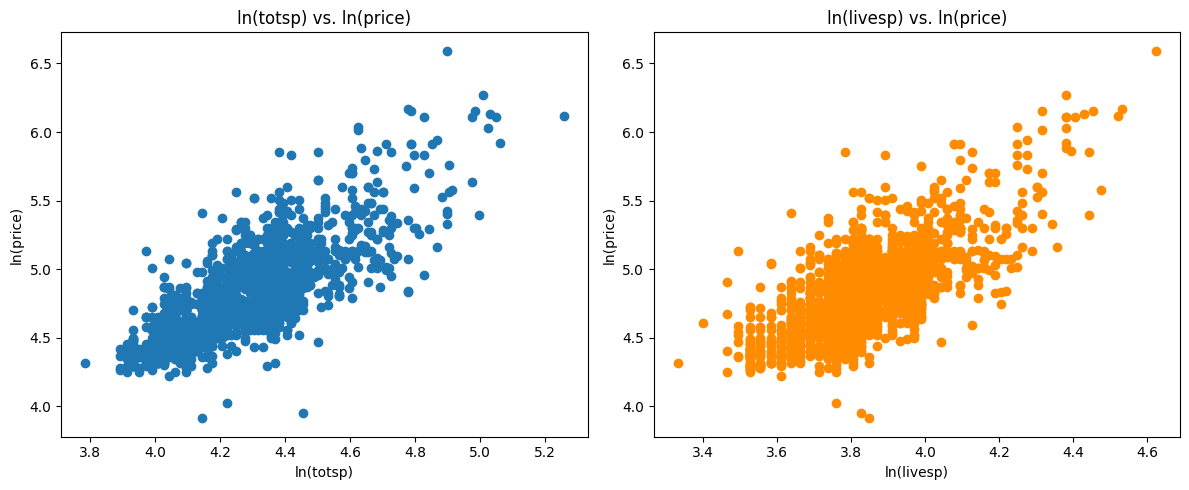

In [8]:
# scatter plot, totsp - blue, livesp - orange
# it looks much better than previous one
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))  # Adjust figsize as needed

# First subplot: totsp vs. price
axes[0].scatter(x=np.log(df.totsp), y=np.log(df.price))
axes[0].set_title('ln(totsp) vs. ln(price)')
axes[0].set_xlabel('ln(totsp)')
axes[0].set_ylabel('ln(price)')

# Second subplot: livesp vs. price
axes[1].scatter(x=np.log(df.livesp), y=np.log(df.price), color='darkorange')
axes[1].set_title('ln(livesp) vs. ln(price)')
axes[1].set_xlabel('ln(livesp)')
axes[1].set_ylabel('ln(price)')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

I will use log(price), log(totsp) and log(livesp) in upcoming modeling

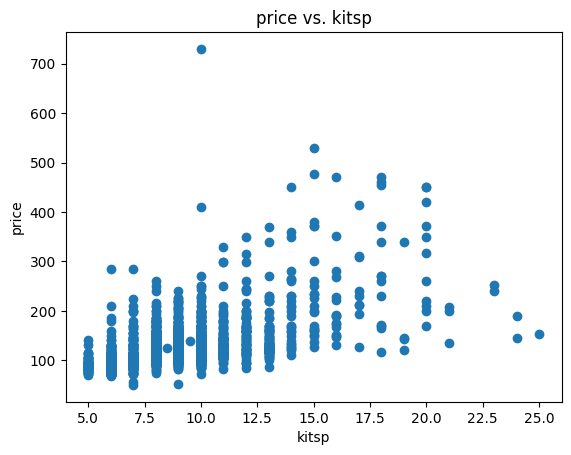

In [9]:
# scatter plot between price and kitsp
plt.scatter(x=df.kitsp, y=df.price)
plt.title("price vs. kitsp")
plt.xlabel("kitsp")
plt.ylabel("price")
plt.show()

Chances are that kitsp is not very informative variable comparing with totsp and livesp, we may observe clasters of flats with similar kitchen area, but different prices. So, the variable may be used as auxiliary variable. All the other variables will be used for the same function.

# Preprocessing of variables

In [10]:
## using logs of variables
for i in ['price', 'totsp', 'livesp']:
    df[f'ln({i})'] = np.log(df[i])
    df = df.drop(columns=i)


In [11]:
# divide data into test and train sample
X = df.drop(['ln(price)'], axis=1)
y = df['ln(price)']
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Modeling

In [12]:
# drop some columns, since they are insignificant in forthcoming regression model
# regression model
m1 = OLS(y_train,X_train).fit()
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:              ln(price)   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     439.6
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:15:14   Log-Likelihood:                 916.88
No. Observations:                1836   AIC:                            -1802.
Df Residuals:                    1820   BIC:                            -1714.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4395      0.118      3.721      0.0

Let us remove insignificant variables and recalculate the model

In [13]:
X_train = X_train.drop(columns = ['code_4', 'code_8', 'ln(livesp)'])
m2 = OLS(y_train,X_train).fit()
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:              ln(price)   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     549.2
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:15:14   Log-Likelihood:                 915.30
No. Observations:                1836   AIC:                            -1805.
Df Residuals:                    1823   BIC:                            -1733.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4444      0.117      3.808      0.0

In [14]:
## Checking for multicollinarity
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.drop(columns='const').columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.drop(columns='const').values, i)
                          for i in range(len(X_train.drop(columns='const').columns))]
  
print(vif_data)

      feature        VIF
0       kitsp  15.335100
1        dist  15.698153
2    metrdist   5.561759
3        walk   3.480366
4       brick   1.948524
5       floor   4.850336
6      code_2   1.522704
7      code_3   1.617625
8      code_5   1.617586
9      code_6   1.411481
10     code_7   1.385734
11  ln(totsp)  51.612917


ln(totsp), kitsp, dist causes multicollinearity of the model. We need to handle it.

# Optimization of the model

In [15]:
pipeline = Pipeline([
('pca', PCA()),  
('regressor', Lasso())
])

param_grid = {
    'regressor': [Lasso(), Ridge(), HuberRegressor()],
    'pca': [PCA()],         
    'pca__n_components': [None, range(1, 8)],
    'regressor__alpha': [0.01, 0.1, 1.0, 10, 100]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_percentage_error', verbose=1, n_jobs=10)
%time grid_search.fit(X, y)

print("Best params :", grid_search.best_params_)
print("Best Mape %.4f" % -grid_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
CPU times: total: 312 ms
Wall time: 3.72 s
Best params : {'pca': PCA(), 'pca__n_components': None, 'regressor': HuberRegressor(alpha=0.1), 'regressor__alpha': 0.1}
Best Mape 0.0218


# Final model

In [16]:
model_final = grid_search.best_params_['regressor'].fit(X, y)

In [17]:
print(pd.DataFrame({'feature':model_final.feature_names_in_, 'coef': model_final.coef_}))

       feature      coef
0        const  0.245362
1        kitsp  0.013113
2         dist -0.021041
3     metrdist -0.008225
4         walk  0.078762
5        brick  0.028628
6        floor  0.054819
7       code_2 -0.041221
8       code_3  0.013044
9       code_4  0.002540
10      code_5 -0.176448
11      code_6 -0.128289
12      code_7 -0.096910
13      code_8 -0.072189
14   ln(totsp)  1.043141
15  ln(livesp) -0.006272


In [18]:
print('MAPE of approximation on real data (without logarithm): %.3f'%mape(np.exp(y), np.exp(model_final.predict(X))))

MAPE of approximation on real data (without logarithm): 0.105
